# License Plate Detection - Data Collection and Exploration
This notebook trains the License Plate Detector model using the Tensorflow Object Detection API.

Main steps:
- Download the pre-trained model from the detection model zoo, which is needed for the training
- Train a finetuned model for the License Plate Detection
- Convert the finetuned model into a TFLite model that can be used by the Android app.
- Test the trained License Plate Detection model

The following diagram shows the directory structure that is created when executing the individual steps of this notebook:

Import common modules...

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import matplotlib

from distutils.version import StrictVersion
from matplotlib import pyplot as plt
from PIL import Image

Check the Tensorflow version...

In [2]:
print ("Tensorflow: {}".format(tf.__version__))

if StrictVersion(tf.__version__.split('-')[0]) < StrictVersion('1.13.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v1.13.0')

if StrictVersion(tf.__version__.split('-')[0]) >= StrictVersion('2.0.0'):
    raise ImportError('Please downgrade your TensorFlow installation to v1.13.*.')

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print(f"GPU device: {device_name}")

Tensorflow: 1.13.2
GPU device: /device:GPU:0


Environment setup for the Tensorflow Object Detection API

In [3]:
os.chdir(os.path.join(os.getcwd(), 'tf_object_detection'))
working_dir = os.getcwd()

sys.path.append(working_dir)
sys.path.append(working_dir + "/slim")

path = working_dir + ';' + working_dir + '/slim' + ';' + working_dir + '/object_detection'
os.environ['PYTHONPATH'] = path

os.chdir(os.path.join(os.getcwd(), 'object_detection'))

Import the modules form the Tensorflow Object Detection API

In [3]:
import object_detection

### Model preparation
The Tensorflow Object Detection API requires a pretrained model as a basis for the training. Depending on the requirements, a suitable model must be selected from the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md). This model must be downloaded into the `models` directory of the object detection api and unpacked there before the training. 

For this project I use the `ssdlite_mobilenet_v2_coco_2018_05_09` model, because it has a good balance between accuracy and speed, which is important for use with a mobile device. However, by adjusting the variables `MODEL` and `PIPELINE_CONFING_FILENAME`, other pretrained models can also be used for training.

Furthermore, the number of classes to be trained `NUM_CLASSES` must be defined. Currently, our data collection only contains pictures of German license plates of class `GER`, therefore the number of classes is set to `1`. 

In [4]:
# choose pretrained model
MODEL = 'ssdlite_mobilenet_v2_coco_2018_05_09'
PIPELINE_CONFING_FILENAME = 'ssdlite_mobilenet_v2_coco.config'

#MODEL = 'ssd_mobilenet_v2_coco_2018_03_29'
#PIPELINE_CONFING_FILENAME = 'ssd_mobilenet_v2.config'

NUM_CLASSES = 1

Define variables for often used directories and files

In [5]:
# ****************** don't edit ******************

# What model to download.
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
PRETRAIND_MODELS_DIR = 'models'

# List of the strings that is used to add correct label for each box.
DETECTION_COFIG_DIR = '../../config/plate_detection'
PATH_TO_LABELS = os.path.join(DETECTION_COFIG_DIR, 'labels_map.pbtxt')

PIPELINE_CONFING_FILEPATH = os.path.join(DETECTION_COFIG_DIR, PIPELINE_CONFING_FILENAME)

OUTPUT_DIR = '../../output/plate_detection'
CHECKPOINTS_DIR = OUTPUT_DIR + '/checkpoints/' + MODEL
FINETUNED_MODEL_DIR = OUTPUT_DIR + '/fine_tuned_models/' + MODEL

# Path to frozen detection graph.
PATH_TO_FROZEN_GRAPH = os.path.join(FINETUNED_MODEL_DIR, 'frozen_inference_graph.pb')

TFLITE_MODEL_PATH = os.path.join(OUTPUT_DIR, 'glpd-model.tflite')

print ('Labels file:           {}'.format(PATH_TO_LABELS))
print ('Pipeline config file:  {}'.format(PIPELINE_CONFING_FILEPATH))
print ('Checkpoints directory: {}'.format(CHECKPOINTS_DIR))
print ('Frozen model file:     {}'.format(PATH_TO_FROZEN_GRAPH))
print ('TFLite model file:     {}'.format(TFLITE_MODEL_PATH))

Labels file:           ../../config/plate_detection\labels_map.pbtxt
Pipeline config file:  ../../config/plate_detection\ssdlite_mobilenet_v2_coco.config
Checkpoints directory: ../../output/plate_detection/checkpoints/ssdlite_mobilenet_v2_coco_2018_05_09
Frozen model file:     ../../output/plate_detection/fine_tuned_models/ssdlite_mobilenet_v2_coco_2018_05_09\frozen_inference_graph.pb
TFLite model file:     ../../output/plate_detection\glpd-model.tflite


# Train License Plate Detection Model
This section describes the necessary steps to train the License Plate Detection model and convert it into a TFLite model that can be used by the Android app.

**NOTE:** If you have already trained and exported the license plate detection model, you can skip the training- and export steps and proceed directly with testing...

### Download Pretrained Model
Download and extract the pretrained model into the models directory of the object detection api. 

**NOTE:** This step only needs to be done once if the pretrained model has not been downloaded yet!

In [8]:
MODEL_ZIP = os.path.join(PRETRAIND_MODELS_DIR, MODEL_FILE)
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_ZIP)
tar_file = tarfile.open(MODEL_ZIP)
tar_file.extractall(os.path.join(os.getcwd(), PRETRAIND_MODELS_DIR))
tar_file.close()

### Train Finetuned Model

Starts the training of the finetuned detection model. This step may take several hours, depending on the computing power of your computer.

You can monitor the training process with `Tensorboard` by running the command `tensorboard --logdir=%CHECKPOINTS_DIR%` in another console. The training process can optionally be interrupted as soon as the desired accuracy is reached.

The parameter `pipeline_config_path` refers to the configuration file for the training, `model_dir` determines in which directory the trained model is stored.

In [9]:
%run model_main.py --pipeline_config_path={PIPELINE_CONFING_FILEPATH} --model_dir={CHECKPOINTS_DIR}


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Maybe overwriting train_steps: None
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
INFO:tensorflow:Maybe overwriting load_pretrained: True
INFO:tensorflow:Ignoring config override key: load_pretrained
INFO:tensorflow:create_estimator_and_inputs: use_tpu False, export_to_tpu False
INFO:tensorflow:Using config: {'_model_dir': '../../output/plate_detection/checkpoints/ssdlite_mobilenet_v2_coco_2018_05_09', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-03-19T08:28:22Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../../output/plate_detection/checkpoints/ssdlite_mobilenet_v2_coco_2018_05_09\model.ckpt-855
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
creating index...
index created!
INFO:tensorflow:Loading and preparing annotation results...
INFO:tensorflow:DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.610
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0

INFO:tensorflow:Restoring parameters from ../../output/plate_detection/checkpoints/ssdlite_mobilenet_v2_coco_2018_05_09\model.ckpt-2579
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
creating index...
index created!
INFO:tensorflow:Loading and preparing annotation results...
INFO:tensorflow:DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.237
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.638
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.083
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.259
 Average Reca

INFO:tensorflow:loss = 1.15449, step = 4500 (66.757 sec)
INFO:tensorflow:global_step/sec: 1.49667
INFO:tensorflow:loss = 1.4678464, step = 4600 (66.852 sec)
INFO:tensorflow:global_step/sec: 1.49766
INFO:tensorflow:loss = 1.005231, step = 4700 (66.734 sec)
INFO:tensorflow:global_step/sec: 1.50182
INFO:tensorflow:loss = 0.92626345, step = 4800 (66.625 sec)
INFO:tensorflow:global_step/sec: 1.49167
INFO:tensorflow:loss = 0.8529773, step = 4900 (67.000 sec)
INFO:tensorflow:global_step/sec: 1.49546
INFO:tensorflow:loss = 1.5095397, step = 5000 (66.909 sec)
INFO:tensorflow:global_step/sec: 1.49954
INFO:tensorflow:loss = 1.2841446, step = 5100 (66.646 sec)
INFO:tensorflow:Saving checkpoints for 5199 into ../../output/plate_detection/checkpoints/ssdlite_mobilenet_v2_coco_2018_05_09\model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv

INFO:tensorflow:loss = 1.0865664, step = 6300 (66.659 sec)
INFO:tensorflow:global_step/sec: 1.49555
INFO:tensorflow:loss = 0.94096315, step = 6400 (66.900 sec)
INFO:tensorflow:global_step/sec: 1.49376
INFO:tensorflow:loss = 1.4803195, step = 6500 (66.910 sec)
INFO:tensorflow:global_step/sec: 1.49968
INFO:tensorflow:loss = 1.5986453, step = 6600 (66.717 sec)
INFO:tensorflow:global_step/sec: 1.49885
INFO:tensorflow:loss = 1.2704717, step = 6700 (66.682 sec)
INFO:tensorflow:global_step/sec: 1.50186
INFO:tensorflow:loss = 1.1615493, step = 6800 (66.615 sec)
INFO:tensorflow:global_step/sec: 1.50143
INFO:tensorflow:loss = 1.2110211, step = 6900 (66.572 sec)
INFO:tensorflow:Saving checkpoints for 6942 into ../../output/plate_detection/checkpoints/ssdlite_mobilenet_v2_coco_2018_05_09\model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional c

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8691: ../../output/plate_detection/checkpoints/ssdlite_mobilenet_v2_coco_2018_05_09\model.ckpt-8691
INFO:tensorflow:global_step/sec: 1.15073
INFO:tensorflow:loss = 1.0506837, step = 8700 (86.865 sec)
INFO:tensorflow:global_step/sec: 1.4763
INFO:tensorflow:loss = 1.3856592, step = 8800 (67.775 sec)
INFO:tensorflow:global_step/sec: 1.44495
INFO:tensorflow:loss = 1.21718, step = 8900 (69.169 sec)
INFO:tensorflow:global_step/sec: 1.45363
INFO:tensorflow:loss = 0.84869945, step = 9000 (68.831 sec)
INFO:tensorflow:global_step/sec: 1.44382
INFO:tensorflow:loss = 0.6278219, step = 9100 (69.223 sec)
INFO:tensorflow:global_step/sec: 1.44446
INFO:tensorflow:loss = 1.0813835, step = 9200 (69.260 sec)
INFO:tensorflow:global_step/sec: 1.44213
INFO:tensorflow:loss = 1.0671682, step = 9300 (69.312 sec)
INFO:tensorflow:global_step/sec: 1.42895
INFO:tensorflow:loss = 1.800957, step = 9400 (70.027 sec)
INFO:tensorflow:global_step/sec: 1.440

INFO:tensorflow:global_step/sec: 1.12936
INFO:tensorflow:loss = 1.010941, step = 10400 (88.546 sec)
INFO:tensorflow:global_step/sec: 1.42787
INFO:tensorflow:loss = 0.95213664, step = 10500 (70.034 sec)
INFO:tensorflow:global_step/sec: 1.43755
INFO:tensorflow:loss = 1.1392139, step = 10600 (69.602 sec)
INFO:tensorflow:global_step/sec: 1.43432
INFO:tensorflow:loss = 0.88647467, step = 10700 (69.680 sec)
INFO:tensorflow:global_step/sec: 1.43397
INFO:tensorflow:loss = 0.6593281, step = 10800 (69.778 sec)
INFO:tensorflow:global_step/sec: 1.44721
INFO:tensorflow:loss = 0.8780678, step = 10900 (69.057 sec)
INFO:tensorflow:global_step/sec: 1.44355
INFO:tensorflow:loss = 1.4664309, step = 11000 (69.319 sec)
INFO:tensorflow:global_step/sec: 1.42309
INFO:tensorflow:loss = 1.140446, step = 11100 (70.226 sec)
INFO:tensorflow:global_step/sec: 1.45215
INFO:tensorflow:loss = 0.92941934, step = 11200 (68.898 sec)
INFO:tensorflow:Saving checkpoints for 11207 into ../../output/plate_detection/checkpoints

INFO:tensorflow:global_step/sec: 1.46194
INFO:tensorflow:loss = 0.94004726, step = 12200 (68.444 sec)
INFO:tensorflow:global_step/sec: 1.47808
INFO:tensorflow:loss = 0.8218641, step = 12300 (67.613 sec)
INFO:tensorflow:global_step/sec: 1.47704
INFO:tensorflow:loss = 0.7183353, step = 12400 (67.738 sec)
INFO:tensorflow:global_step/sec: 1.47936
INFO:tensorflow:loss = 1.0222881, step = 12500 (67.562 sec)
INFO:tensorflow:global_step/sec: 1.48217
INFO:tensorflow:loss = 1.135624, step = 12600 (67.505 sec)
INFO:tensorflow:global_step/sec: 1.44655
INFO:tensorflow:loss = 0.98489416, step = 12700 (69.094 sec)
INFO:tensorflow:global_step/sec: 1.44853
INFO:tensorflow:loss = 0.7271623, step = 12800 (69.074 sec)
INFO:tensorflow:Saving checkpoints for 12896 into ../../output/plate_detection/checkpoints/ssdlite_mobilenet_v2_coco_2018_05_09\model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box p

INFO:tensorflow:global_step/sec: 1.44354
INFO:tensorflow:loss = 0.9837433, step = 14000 (69.314 sec)
INFO:tensorflow:global_step/sec: 1.4487
INFO:tensorflow:loss = 0.87653965, step = 14100 (68.987 sec)
INFO:tensorflow:global_step/sec: 1.42799
INFO:tensorflow:loss = 0.83445454, step = 14200 (70.062 sec)
INFO:tensorflow:global_step/sec: 1.44293
INFO:tensorflow:loss = 0.7395476, step = 14300 (69.269 sec)
INFO:tensorflow:global_step/sec: 1.43528
INFO:tensorflow:loss = 1.1022322, step = 14400 (69.708 sec)
INFO:tensorflow:global_step/sec: 1.45447
INFO:tensorflow:loss = 1.6423279, step = 14500 (68.718 sec)
INFO:tensorflow:Saving checkpoints for 14573 into ../../output/plate_detection/checkpoints/ssdlite_mobilenet_v2_coco_2018_05_09\model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of

INFO:tensorflow:global_step/sec: 1.44707
INFO:tensorflow:loss = 0.8292337, step = 15800 (69.140 sec)
INFO:tensorflow:global_step/sec: 1.45888
INFO:tensorflow:loss = 0.95862114, step = 15900 (68.512 sec)
INFO:tensorflow:global_step/sec: 1.45402
INFO:tensorflow:loss = 0.9625826, step = 16000 (68.814 sec)
INFO:tensorflow:global_step/sec: 1.44038
INFO:tensorflow:loss = 0.692822, step = 16100 (69.387 sec)
INFO:tensorflow:global_step/sec: 1.45351
INFO:tensorflow:loss = 0.9837079, step = 16200 (68.839 sec)
INFO:tensorflow:Saving checkpoints for 16254 into ../../output/plate_detection/checkpoints/ssdlite_mobilenet_v2_coco_2018_05_09\model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor

INFO:tensorflow:loss = 0.94465315, step = 17500 (68.612 sec)
INFO:tensorflow:global_step/sec: 1.46011
INFO:tensorflow:loss = 0.89534235, step = 17600 (68.530 sec)
INFO:tensorflow:global_step/sec: 1.44603
INFO:tensorflow:loss = 0.9910918, step = 17700 (69.114 sec)
INFO:tensorflow:global_step/sec: 1.43817
INFO:tensorflow:loss = 0.9624667, step = 17800 (69.570 sec)
INFO:tensorflow:global_step/sec: 1.42493
INFO:tensorflow:loss = 1.1233175, step = 17900 (70.141 sec)
INFO:tensorflow:Saving checkpoints for 17939 into ../../output/plate_detection/checkpoints/ssdlite_mobilenet_v2_coco_2018_05_09\model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 19656: ../../output/plate_detection/checkpoints/ssdlite_mobilenet_v2_coco_2018_05_09\model.ckpt-19656
INFO:tensorflow:global_step/sec: 1.1204
INFO:tensorflow:loss = 0.96019304, step = 19700 (89.215 sec)
INFO:tensorflow:global_step/sec: 1.46942
INFO:tensorflow:loss = 1.1612241, step = 19800 (68.092 sec)
INFO:tensorflow:global_step/sec: 1.45943
INFO:tensorflow:loss = 0.90889525, step = 19900 (68.482 sec)
INFO:tensorflow:global_step/sec: 1.47427
INFO:tensorflow:loss = 1.0569578, step = 20000 (67.868 sec)
INFO:tensorflow:global_step/sec: 1.48896
INFO:tensorflow:loss = 0.7525408, step = 20100 (67.123 sec)
INFO:tensorflow:global_step/sec: 1.47172
INFO:tensorflow:loss = 0.8056678, step = 20200 (67.987 sec)
INFO:tensorflow:global_step/sec: 1.44081
INFO:tensorflow:loss = 0.7080721, step = 20300 (69.366 sec)
INFO:tensorflow:global_step/sec: 1.4448
INFO:tensorflow:loss = 1.0656219, step = 20400 (69.250 sec)
INFO:tensorflow:global_st

INFO:tensorflow:global_step/sec: 1.16939
INFO:tensorflow:loss = 0.85479987, step = 21400 (85.557 sec)
INFO:tensorflow:global_step/sec: 1.48949
INFO:tensorflow:loss = 0.8920213, step = 21500 (67.095 sec)
INFO:tensorflow:global_step/sec: 1.49592
INFO:tensorflow:loss = 1.1687762, step = 21600 (66.880 sec)
INFO:tensorflow:global_step/sec: 1.48864
INFO:tensorflow:loss = 0.934783, step = 21700 (67.143 sec)
INFO:tensorflow:global_step/sec: 1.49368
INFO:tensorflow:loss = 0.95636714, step = 21800 (66.992 sec)
INFO:tensorflow:global_step/sec: 1.4851
INFO:tensorflow:loss = 0.71755, step = 21900 (67.292 sec)
INFO:tensorflow:global_step/sec: 1.48859
INFO:tensorflow:loss = 0.75662297, step = 22000 (67.216 sec)
INFO:tensorflow:global_step/sec: 1.48655
INFO:tensorflow:loss = 0.69293207, step = 22100 (67.231 sec)
INFO:tensorflow:global_step/sec: 1.49074
INFO:tensorflow:loss = 0.7609881, step = 22200 (67.121 sec)
INFO:tensorflow:Saving checkpoints for 22241 into ../../output/plate_detection/checkpoints/

INFO:tensorflow:global_step/sec: 1.17076
INFO:tensorflow:loss = 0.73842514, step = 23200 (85.455 sec)
INFO:tensorflow:global_step/sec: 1.47969
INFO:tensorflow:loss = 0.8306948, step = 23300 (67.542 sec)
INFO:tensorflow:global_step/sec: 1.48086
INFO:tensorflow:loss = 1.1193265, step = 23400 (67.568 sec)
INFO:tensorflow:global_step/sec: 1.47569
INFO:tensorflow:loss = 0.85236585, step = 23500 (67.726 sec)
INFO:tensorflow:global_step/sec: 1.48385
INFO:tensorflow:loss = 0.8683617, step = 23600 (67.433 sec)
INFO:tensorflow:global_step/sec: 1.47907
INFO:tensorflow:loss = 1.1522877, step = 23700 (67.568 sec)
INFO:tensorflow:global_step/sec: 1.48336
INFO:tensorflow:loss = 0.83733094, step = 23800 (67.458 sec)
INFO:tensorflow:global_step/sec: 1.49379
INFO:tensorflow:loss = 0.9194144, step = 23900 (66.902 sec)
INFO:tensorflow:Saving checkpoints for 23972 into ../../output/plate_detection/checkpoints/ssdlite_mobilenet_v2_coco_2018_05_09\model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow

INFO:tensorflow:global_step/sec: 1.48497
INFO:tensorflow:loss = 0.74753, step = 25000 (67.384 sec)
INFO:tensorflow:global_step/sec: 1.47004
INFO:tensorflow:loss = 0.76253533, step = 25100 (67.983 sec)
INFO:tensorflow:global_step/sec: 1.4892
INFO:tensorflow:loss = 0.74824834, step = 25200 (67.191 sec)
INFO:tensorflow:global_step/sec: 1.49154
INFO:tensorflow:loss = 0.9347792, step = 25300 (67.004 sec)
INFO:tensorflow:global_step/sec: 1.48185
INFO:tensorflow:loss = 0.7274184, step = 25400 (67.513 sec)
INFO:tensorflow:global_step/sec: 1.49272
INFO:tensorflow:loss = 0.92040145, step = 25500 (66.962 sec)
INFO:tensorflow:global_step/sec: 1.48432
INFO:tensorflow:loss = 0.8131157, step = 25600 (67.406 sec)
INFO:tensorflow:Saving checkpoints for 25698 into ../../output/plate_detection/checkpoints/ssdlite_mobilenet_v2_coco_2018_05_09\model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box pr

INFO:tensorflow:global_step/sec: 1.49077
INFO:tensorflow:loss = 1.3362232, step = 26800 (67.124 sec)
INFO:tensorflow:global_step/sec: 1.48957
INFO:tensorflow:loss = 0.81450486, step = 26900 (67.090 sec)
INFO:tensorflow:global_step/sec: 1.49139
INFO:tensorflow:loss = 0.7671349, step = 27000 (67.095 sec)
INFO:tensorflow:global_step/sec: 1.48029
INFO:tensorflow:loss = 0.93443835, step = 27100 (67.511 sec)
INFO:tensorflow:global_step/sec: 1.48167
INFO:tensorflow:loss = 0.7419409, step = 27200 (67.530 sec)
INFO:tensorflow:global_step/sec: 1.48566
INFO:tensorflow:loss = 1.0361524, step = 27300 (67.270 sec)
INFO:tensorflow:global_step/sec: 1.48885
INFO:tensorflow:loss = 1.0047721, step = 27400 (67.206 sec)
INFO:tensorflow:Saving checkpoints for 27428 into ../../output/plate_detection/checkpoints/ssdlite_mobilenet_v2_coco_2018_05_09\model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box 

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 29178: ../../output/plate_detection/checkpoints/ssdlite_mobilenet_v2_coco_2018_05_09\model.ckpt-29178
INFO:tensorflow:global_step/sec: 1.15515
INFO:tensorflow:loss = 0.7726994, step = 29200 (86.569 sec)
INFO:tensorflow:global_step/sec: 1.4851
INFO:tensorflow:loss = 0.7741491, step = 29300 (67.336 sec)
INFO:tensorflow:global_step/sec: 1.49373
INFO:tensorflow:loss = 0.9503962, step = 29400 (66.984 sec)
INFO:tensorflow:global_step/sec: 1.48015
INFO:tensorflow:loss = 0.81622875, step = 29500 (67.524 sec)
INFO:tensorflow:global_step/sec: 1.48501
INFO:tensorflow:loss = 0.84110355, step = 29600 (67.377 sec)
INFO:tensorflow:global_step/sec: 1.47986
INFO:tensorflow:loss = 0.6561331, step = 29700 (67.537 sec)
INFO:tensorflow:global_step/sec: 1.48746
INFO:tensorflow:loss = 0.9272151, step = 29800 (67.264 sec)
INFO:tensorflow:global_step/sec: 1.46809
INFO:tensorflow:loss = 0.58915424, step = 29900 (68.080 sec)
INFO:tensorflow:Saving 

NotFoundError: Failed to create a directory: ../../output/plate_detection/checkpoints/ssdlite_mobilenet_v2_coco_2018_05_09\export\Servo\temp-b'1584626899'; No such file or directory

AttributeError: 'function' object has no attribute 'called'

### Export Finetuned Model
If the training is finished, the model must be converted into a TFLite model, that can be used by the Android app.

For this, the checkpoint to be converted must be specified. Since we have defined 30000 training steps in our pipeline-config file, we use checkpoint 30000, but optionally earlier checkpoints can be used. To adjust the checkpoint to be used we use the variable `CHECKPOINT_NO`

In [10]:
CHECKPOINT_NO = 30000

In [12]:
!python export_inference_graph.py \
    --pipeline_config_path={PIPELINE_CONFING_FILEPATH} \
    --trained_checkpoint_prefix={CHECKPOINTS_DIR}/model.ckpt-{CHECKPOINT_NO} \
    --output_directory={FINETUNED_MODEL_DIR}

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step

Parsing Inputs...

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              0
-min_occurrence             0
-step                       -1
-order_by                   name
-account_type_regexes       _trainable_variables
-start_name_regexes         .*
-trim_name_regexes          .*BatchNorm.*
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     params
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
param: Number of parameters (in the Variable).

Profile:
node


Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
Incomplete shape.
Incomplete shape.
Incomplete shape.
Incomplete shape.
2020-03-20 15:23:28.068079: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
2020-03-20 15:23:28.183538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1433] Found device 0 with properties: 
name: GeForce RTX 2070 major: 7 minor: 5 memoryClockRate(GHz): 1.83
pciBusID: 0000:01:00.0
totalMemory: 8.00GiB freeMemory: 6.59GiB
2020-03-20 15:23:28.183858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1512] Adding visible gpu devices: 0
2020-03-20 15:23:28.557820: I tensorflow/core/common_runtime/gpu/gpu_device.cc:984] Device interconnect StreamExecutor with strength 1 edge


    BoxPredictor_2/ClassPredictor_depthwise (--/4.61k params)
      BoxPredictor_2/ClassPredictor_depthwise/BatchNorm (--/0 params)
      BoxPredictor_2/ClassPredictor_depthwise/depthwise_weights (3x3x512x1, 4.61k/4.61k params)
  BoxPredictor_3 (--/13.86k params)
    BoxPredictor_3/BoxEncodingPredictor (--/6.17k params)
      BoxPredictor_3/BoxEncodingPredictor/biases (24, 24/24 params)
      BoxPredictor_3/BoxEncodingPredictor/weights (1x1x256x24, 6.14k/6.14k params)
    BoxPredictor_3/BoxEncodingPredictor_depthwise (--/2.30k params)
      BoxPredictor_3/BoxEncodingPredictor_depthwise/BatchNorm (--/0 params)
      BoxPredictor_3/BoxEncodingPredictor_depthwise/depthwise_weights (3x3x256x1, 2.30k/2.30k params)
    BoxPredictor_3/ClassPredictor (--/3.08k params)
      BoxPredictor_3/ClassPredictor/biases (12, 12/12 params)
      BoxPredictor_3/ClassPredictor/weights (1x1x256x12, 3.07k/3.07k params)
    BoxPredictor_3/ClassPredictor_depthwise (--/2.30k params)
      BoxPredictor_3/ClassP

In [13]:
!python export_tflite_ssd_graph.py \
    --pipeline_config_path={PIPELINE_CONFING_FILEPATH} \
    --trained_checkpoint_prefix={CHECKPOINTS_DIR}/model.ckpt-{CHECKPOINT_NO} \
    --output_directory={OUTPUT_DIR} \
    --add_postprocessing_op=true \
    --max_detections=1 \
    --detections_per_class=1

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
2020-03-20 15:23:43.612121: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
2020-03-20 15:23:43.725182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1433] Found device 0 with properties: 
name: GeForce RTX 2070 major: 7 minor: 5 memoryClockRate(GHz): 1.83
pciBusID: 0000:01:00.0
totalMemory: 8.00GiB freeMemory: 6.59GiB
2020-03-20 15:23:43.725499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1512] Adding visible gpu devices: 0
2020-03-20 15:23:44.083222: I tensorflow/core/common_runtime/gpu/gpu_device.cc:984] Device interconnect StreamExecutor with strength 1 edge matrix:
2020-03-20 15:23:44.083440: I tensorflow/core/common_runtime/gpu/gpu_device.cc:990]      0 
2020-03-20 15:23:44.083563: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1003] 0:   N 
2020-03-20 1

In [14]:
!toco \
    --graph_def_file={OUTPUT_DIR}/tflite_graph.pb \
    --output_file={TFLITE_MODEL_PATH} \
    --input_shapes=1,300,300,3 \
    --input_arrays=normalized_input_image_tensor \
    --output_arrays=TFLite_Detection_PostProcess,TFLite_Detection_PostProcess:1,TFLite_Detection_PostProcess:2,TFLite_Detection_PostProcess:3 \
    --inference_type=FLOAT \
    --allow_custom_ops

2020-03-20 15:24:09.037413: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
2020-03-20 15:24:09.177857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1433] Found device 0 with properties: 
name: GeForce RTX 2070 major: 7 minor: 5 memoryClockRate(GHz): 1.83
pciBusID: 0000:01:00.0
totalMemory: 8.00GiB freeMemory: 6.59GiB
2020-03-20 15:24:09.178189: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1512] Adding visible gpu devices: 0
2020-03-20 15:24:09.538320: I tensorflow/core/common_runtime/gpu/gpu_device.cc:984] Device interconnect StreamExecutor with strength 1 edge matrix:
2020-03-20 15:24:09.538515: I tensorflow/core/common_runtime/gpu/gpu_device.cc:990]      0 
2020-03-20 15:24:09.538624: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1003] 0:   N 
2020-03-20 15:24:09.538830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorFlow device (/job:localhost/repli

# Test License Plate Detection Model
Now it is time to test the trained license plate detection model. For this we load the trained model and perform an inference with some test images. 

### Load label map
First we load the label mab file `PATH_TO_LABELS`, which contains the assignment of class labels to class ids, and create a `category_index`, that maps the categories to indices.

In [7]:
from object_detection.utils import label_map_util

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

print (label_map)
print (categories)
print (category_index)

item {
  name: "GER"
  id: 1
}

[{'id': 1, 'name': 'GER'}]
{1: {'id': 1, 'name': 'GER'}}


Next we create an array `TEST_IMAGE_PATHS` with the file paths of all test images we want to test.

In [10]:
# number of samples to test; -1 <=> all
NUM_SAMPLES = -1

PATH_TO_TEST_IMAGES_DIR = '../../data/plate_detection/test_images'

In [20]:
import glob

TEST_IMAGE_PATHS = []
for filename in glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.jpg')):
    TEST_IMAGE_PATHS.append(filename)
    
print ('{} test images:'.format(len(TEST_IMAGE_PATHS)))

if NUM_SAMPLES > 0:
    test_images = np.random.choice(TEST_IMAGE_PATHS, size = NUM_SAMPLES, replace=False)
else:
    test_images = TEST_IMAGE_PATHS

print (test_images)

32 test images:
['../../data/plate_detection/test_images\\A-CR655.jpg', '../../data/plate_detection/test_images\\A-MB1012.jpg', '../../data/plate_detection/test_images\\B-EG773E.jpg', '../../data/plate_detection/test_images\\B-GN420.jpg', '../../data/plate_detection/test_images\\BC-07129.jpg', '../../data/plate_detection/test_images\\BL-XY9999.jpg', '../../data/plate_detection/test_images\\CW-KO222.jpg', '../../data/plate_detection/test_images\\DEG-FE41E.jpg', '../../data/plate_detection/test_images\\F-JU10.jpg', '../../data/plate_detection/test_images\\FC241ZH.jpg', '../../data/plate_detection/test_images\\FÜ-SZ262.jpg', '../../data/plate_detection/test_images\\GG-XN761.jpg', '../../data/plate_detection/test_images\\HB-01199.jpg', '../../data/plate_detection/test_images\\HH-CZ3874.jpg', '../../data/plate_detection/test_images\\HI-JO500.jpg', '../../data/plate_detection/test_images\\K-OE2037.jpg', '../../data/plate_detection/test_images\\K-QZ1192.jpg', '../../data/plate_detection/test_

### Test Frozen Model Graph
First we test the finetuned License Plate Detection model.

Helper methods for inferenz

In [21]:
from object_detection.utils import visualization_utils as vis_util

import matplotlib.image as mpimg

# This is needed to display the images inside the notebook cells.
%matplotlib inline   
    
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

def run_inference_for_single_image(image, graph):
    if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
    image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

    # Run inference
    output_dict = sess.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})

    # all outputs are float32 numpy arrays, so convert types as appropriate
    output_dict['num_detections'] = int(output_dict['num_detections'][0])
    output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
    output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
    output_dict['detection_scores'] = output_dict['detection_scores'][0]
    if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

Create Tensorflow session for inferenz

In [22]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

Perform inference for all test images...

The result shows all test images in which the detected license plates are marked with a bonding box and tagged with a class label and score.

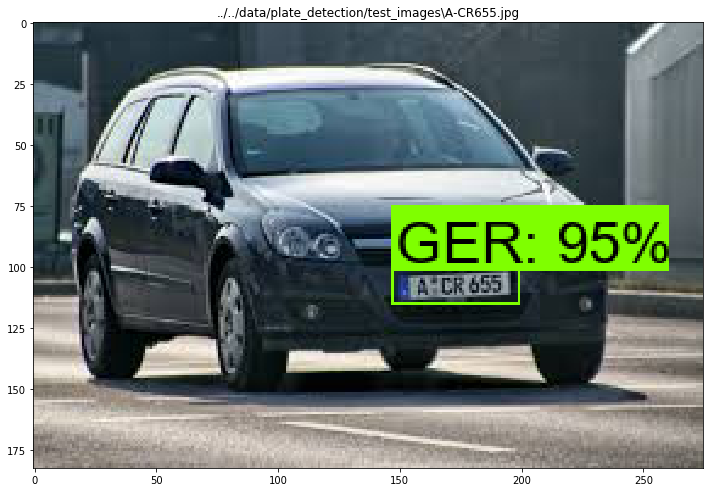

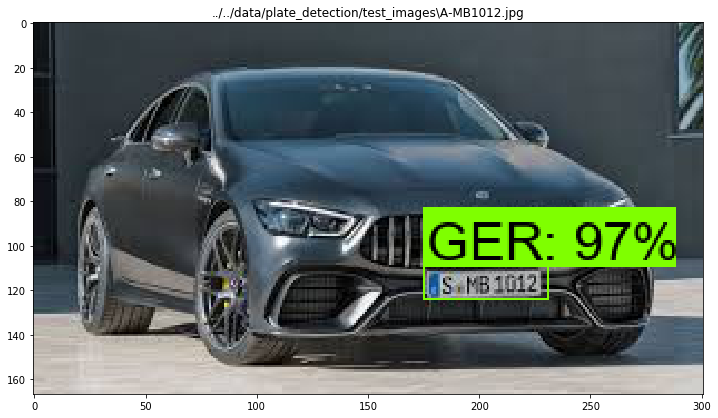

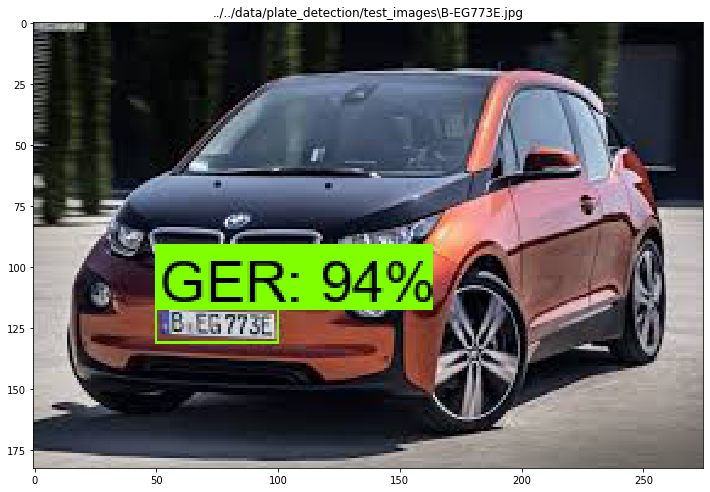

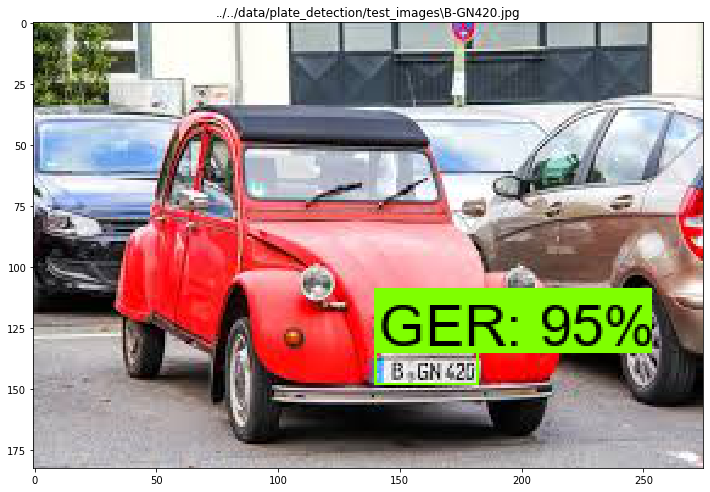

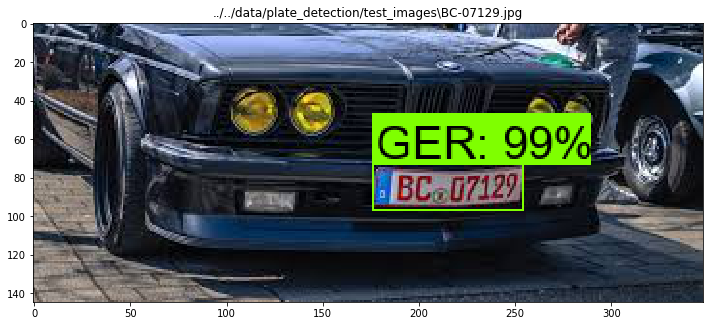

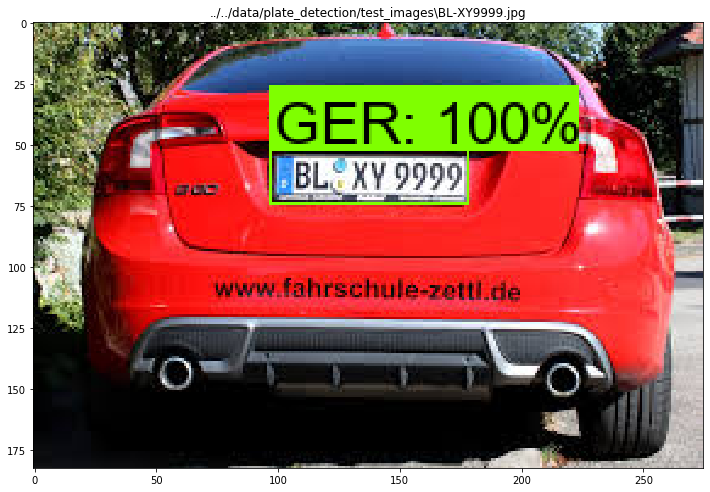

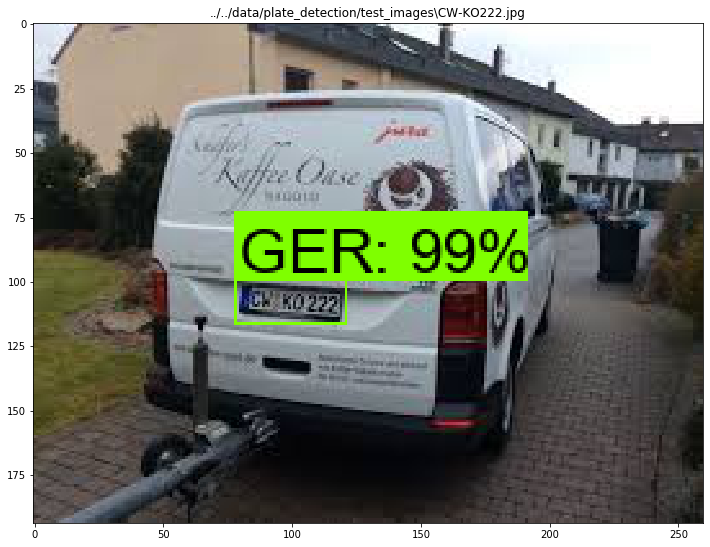

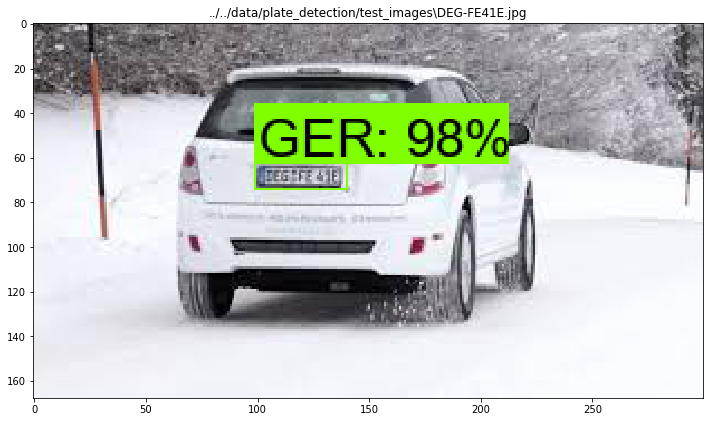

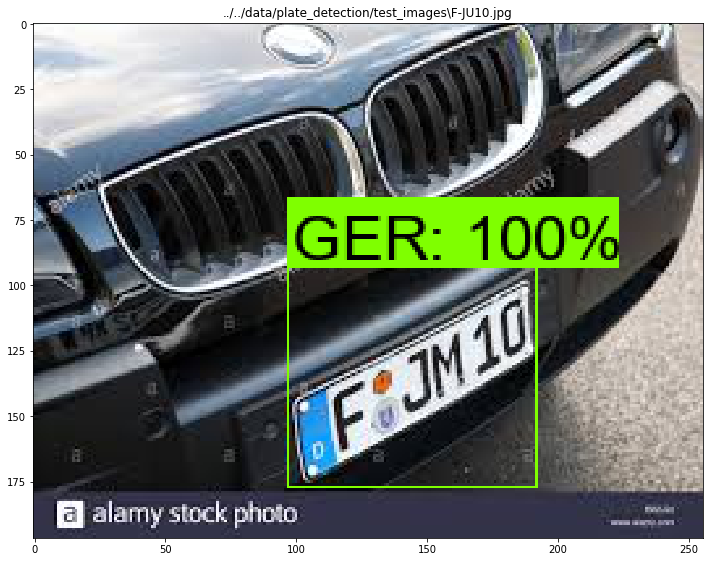

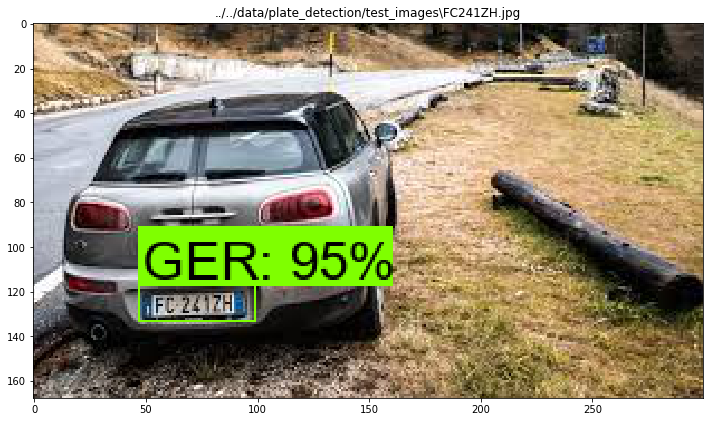

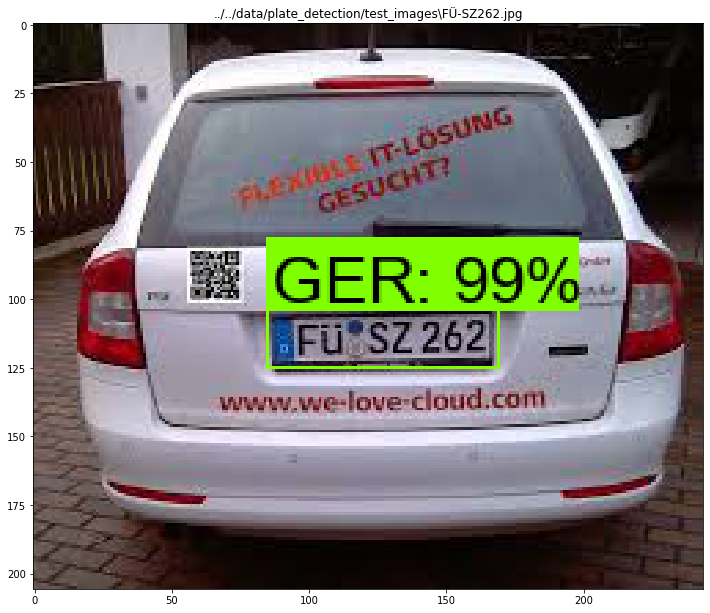

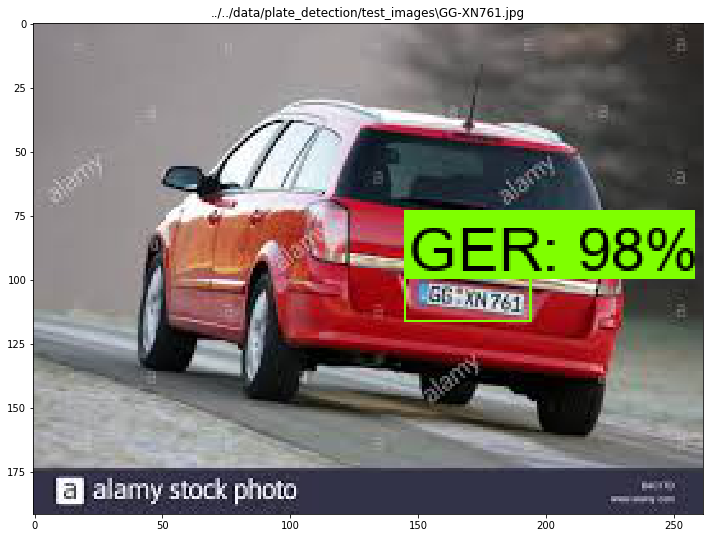

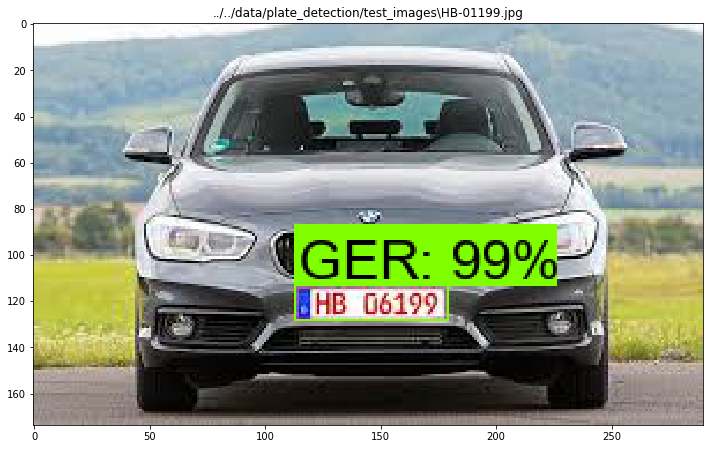

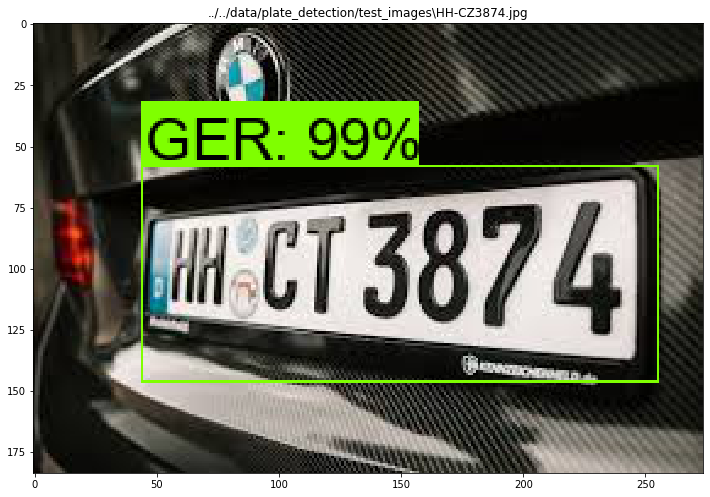

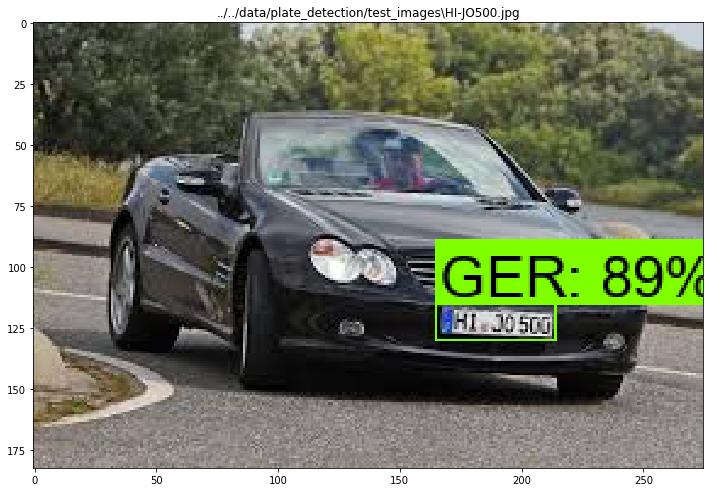

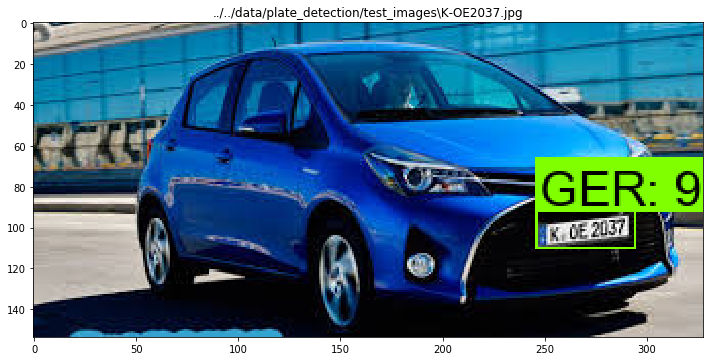

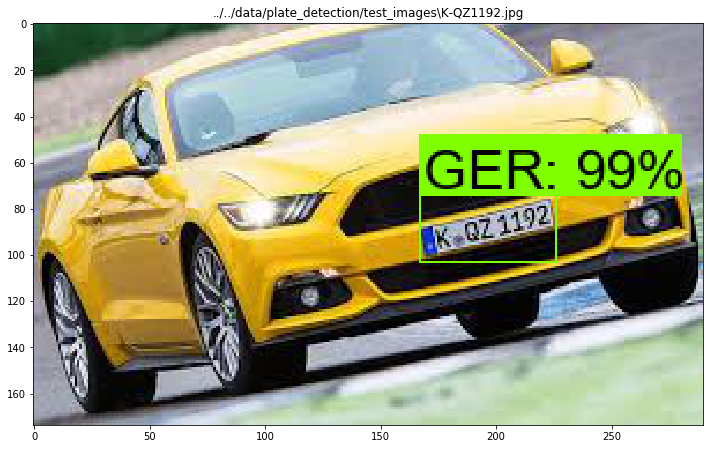

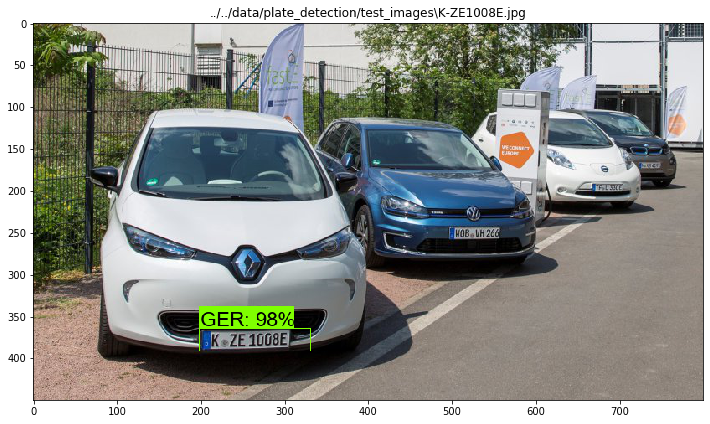

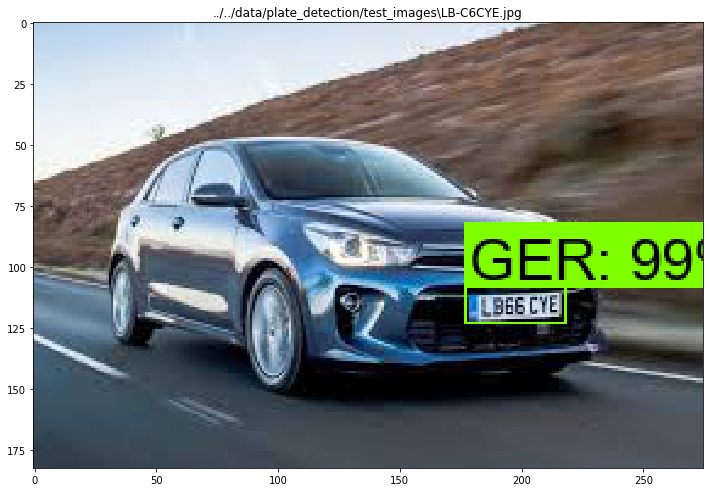

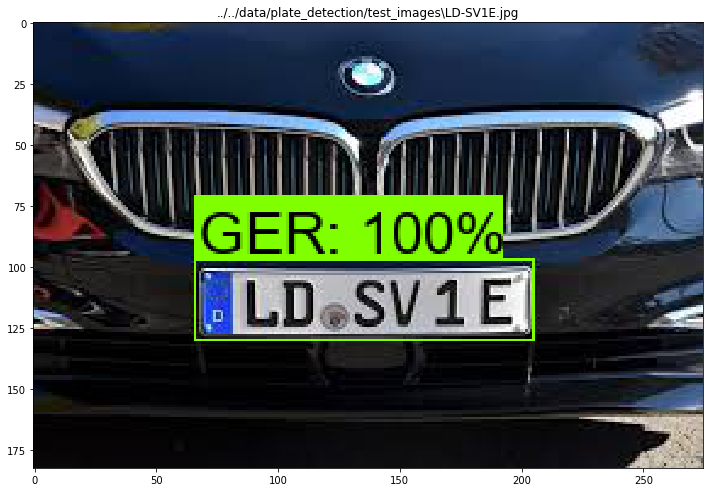

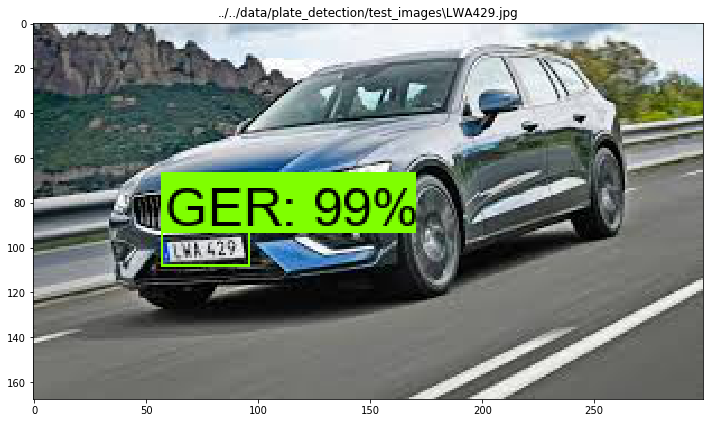

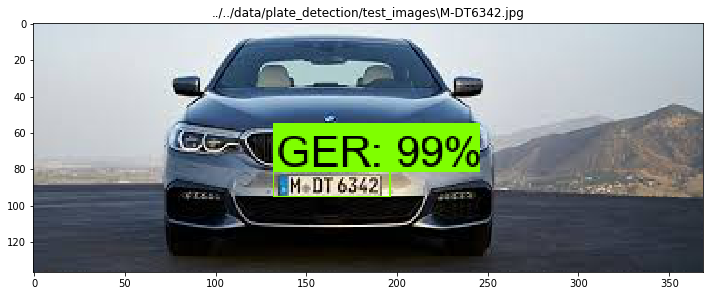

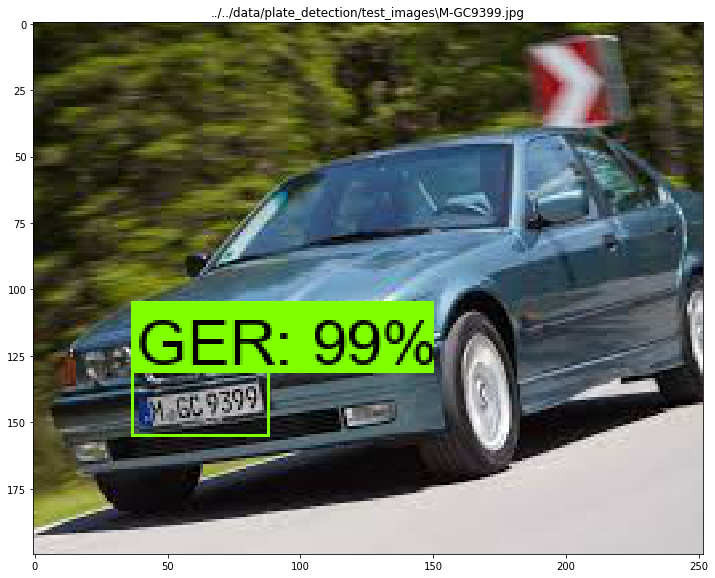

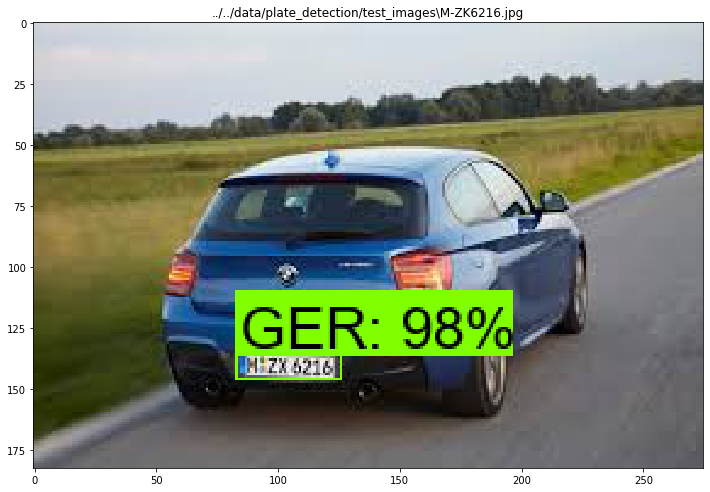

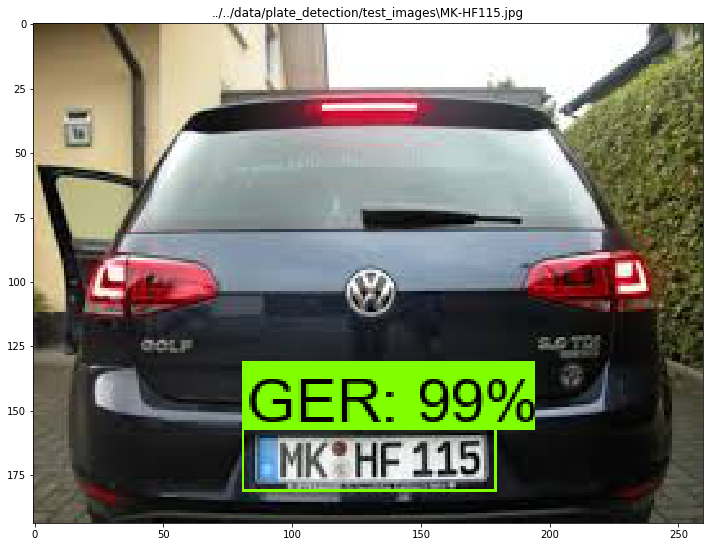

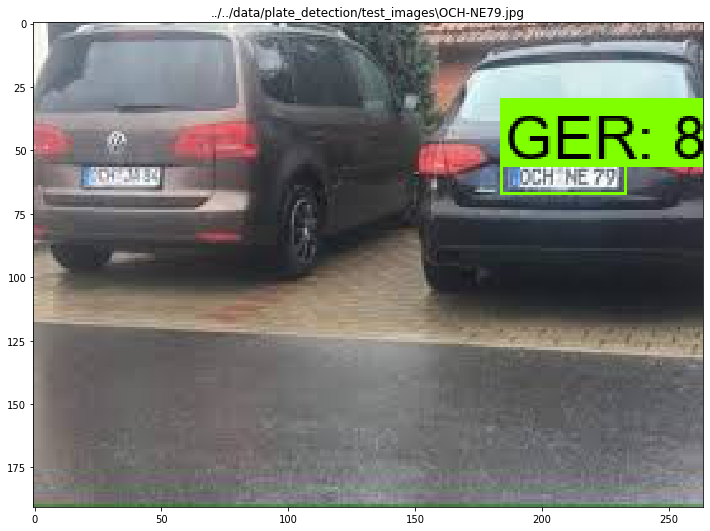

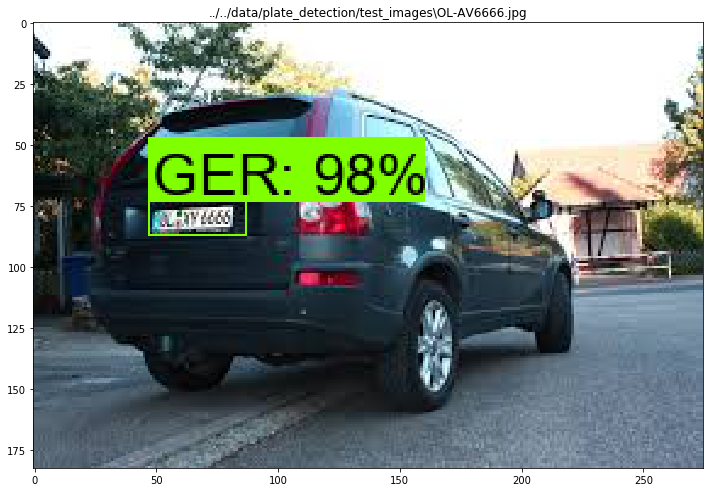

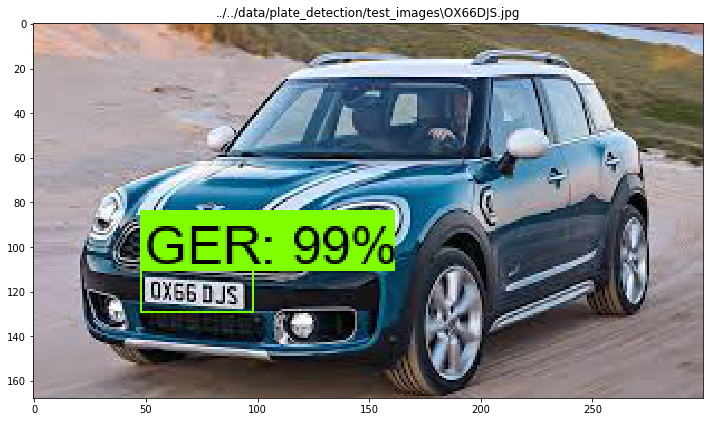

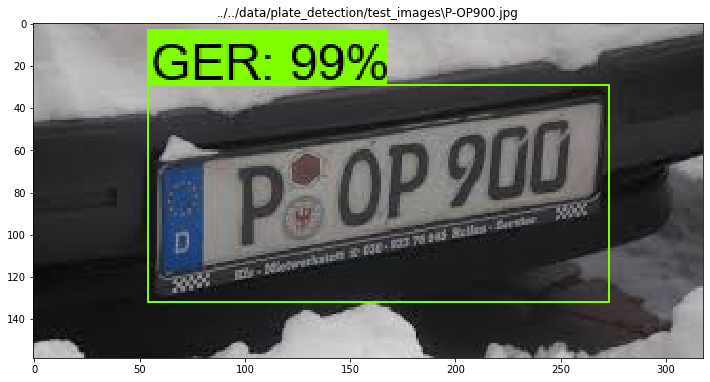

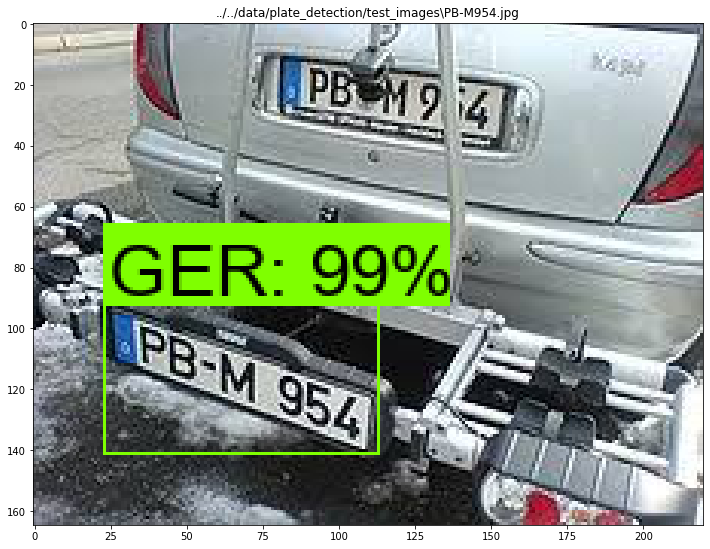

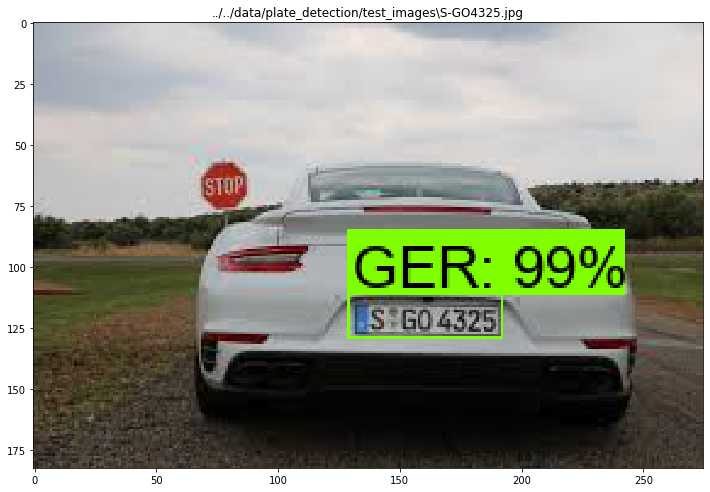

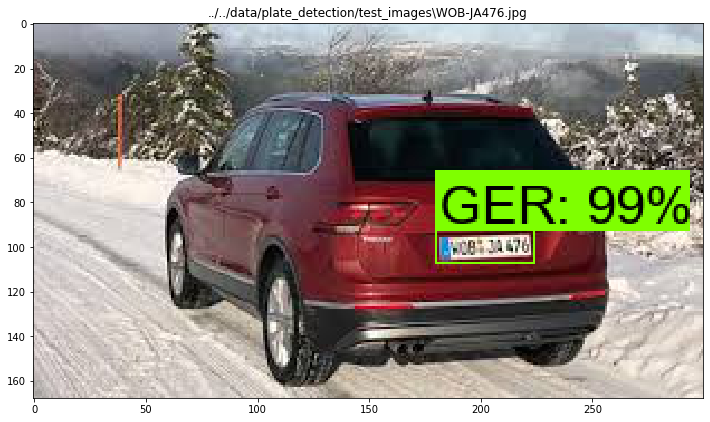

In [23]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
        ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)

        for image_path in test_images:
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            # Actual detection.
            output_dict = run_inference_for_single_image(image_np, detection_graph)
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                output_dict['detection_boxes'],
                output_dict['detection_classes'],
                output_dict['detection_scores'],
                category_index,
                instance_masks=output_dict.get('detection_masks'),
                use_normalized_coordinates=True,
                max_boxes_to_draw=1,
                line_thickness=1,
                min_score_thresh=0.8)
            
            plt.figure(figsize=(12, 12))
            plt.title(image_path)
            plt.imshow(image_np)            
            plt.show()

### Test TFLite Model
Finally we test the TFLite model, which will be used by our Andoid app. For this we select a test image with 'IMG_INDEX' and perform an inferenz.

The result shows the test image in which the detected license plate is marked with a bounding box.

In [30]:
IMG_INDEX = 0

Box: [0.55352676 0.53634256 0.6329502  0.7236622 ]
Class: 0
Score: 0.9535953998565674
Detections: 1


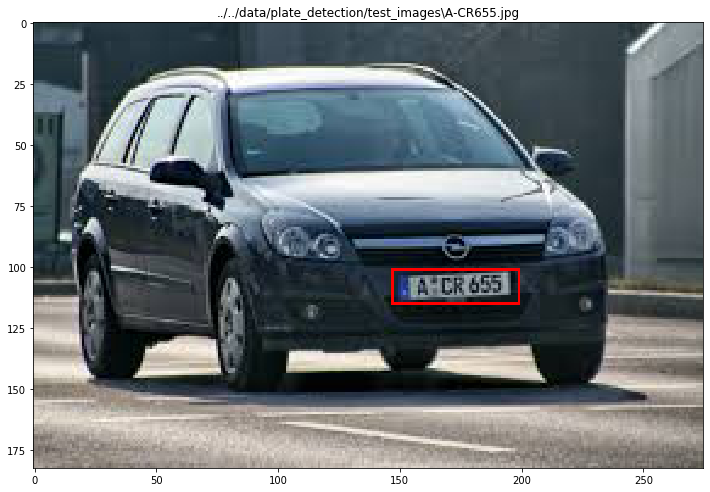

In [31]:
from tensorflow.compat.v1.lite import Interpreter

input_mean = 127.5
input_std = 127.5

# Load TFLite model and allocate tensors.
interpreter = Interpreter(model_path=TFLITE_MODEL_PATH)
interpreter.allocate_tensors()
# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']
output_shape = output_details[0]['shape']

image_path = test_images[IMG_INDEX]
image = Image.open(image_path)
image_np = load_image_into_numpy_array(image.resize((300, 300), Image.ANTIALIAS))
input_data = np.array(np.expand_dims(image_np, axis=0), dtype=np.float32)
input_data = (np.float32(input_data) - input_mean) / input_std

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

detection_box = np.squeeze(interpreter.tensor(output_details[0]['index'])())
print("Box: {}".format(detection_box))

detection_class = np.squeeze(interpreter.tensor(output_details[1]['index'])()).astype(np.uint8)
print("Class: {}".format(detection_class))

detection_score = np.squeeze(interpreter.tensor(output_details[2]['index'])())
print("Score: {}".format(detection_score))

num_detections = np.squeeze(interpreter.tensor(output_details[3]['index'])()).astype(int)
print("Detections: {}".format(num_detections))


image_np = load_image_into_numpy_array(image)

if num_detections > 0 and detection_score > 0.8: 
    ymin, xmin, ymax, xmax = detection_box
    vis_util.draw_bounding_box_on_image_array(image_np, ymin, xmin, ymax, xmax, color='red', thickness=1)            

plt.figure(figsize=(12, 12))
plt.title(image_path)
plt.imshow(image_np)
plt.show()